# Variogram modeling

In this notebook we derive a 3D variogram model. The chosen model and vertical component are based on borehole data, while the correlation length down-dip (along y) and along strike (along x) are inferred from seismic data. Rotational angles in these directions are iteratively determined, in order to find the direction of highest spatial correlation.

In [3]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gstools as gs
import pyvista as pv
import PVGeo
import copy
import scipy.spatial.distance as dist
import scipy
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['axes.grid'] = True

### 1. Load porosity well data

In [4]:
df = pd.read_csv("Data/Wells/Complete_set_corrected.csv")
df.head()

,X,Y,Z,Porosity,Sequence,Well
0,28200,76200,-372.130,10.700,m54,m28
1,28200,76200,-568.730,13.300,m58,m28
2,28200,76200,-671.830,15.000,m58,m28
3,28200,76200,-693.950,15.600,m58,m28
4,28200,76200,-692.000,16.000,m58,m28


## 2. Trend detection

### 2.1 Vertical trend

Determine compaction trend based on core data sampled at 3 m spacing.

In [5]:
# Exponential trend model
def exponential_trend(x, a, b):
    return a*np.exp(b*x)

In [6]:
# Vertical trend calculation and plotting

# using scipy.curve_fit: non-linear least squares to fit a function
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

# Quick rename for simplicity
xdata = df["Z"].values
ydata = df["Porosity"].values
    
# Trend fitting exponential trend
p0 = [41,0.001]
popt_exp, pcov_exp = curve_fit(exponential_trend, xdata, ydata, p0)

# Calculate r^2 exponential
residuals = ydata-exponential_trend(xdata, *popt_exp)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared_exp = 1 - (ss_res / ss_tot)

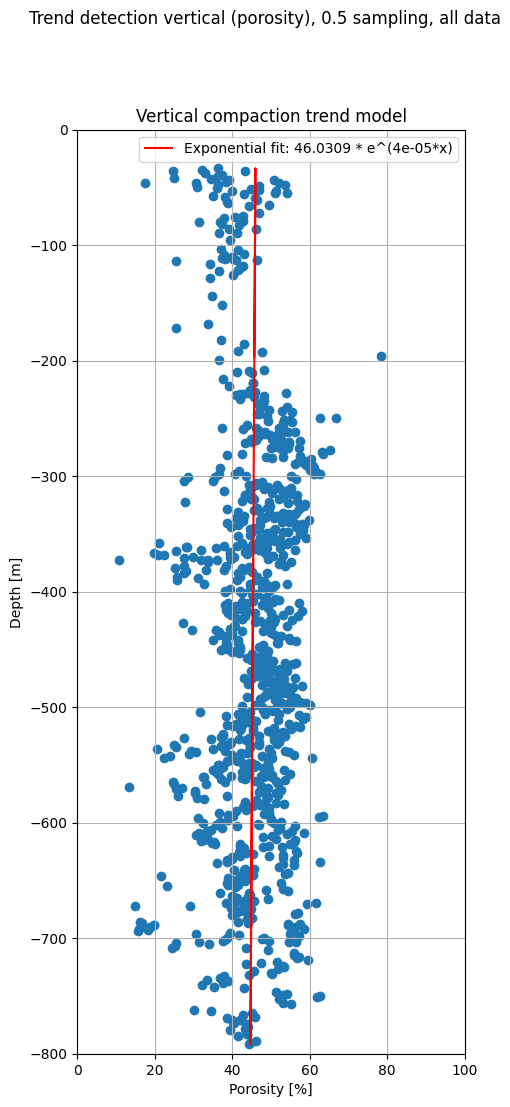

In [7]:
# Create figure
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,12))
fig.suptitle('Trend detection vertical (porosity), 0.5 sampling, all data')

# Plot data
axs.scatter(ydata, xdata)

# Plot exponential trend
axs.plot(exponential_trend(xdata, *popt_exp),xdata, 'r-',
    label='Exponential fit: {} * e^({}*x)'.format(
    np.round(popt_exp[0],4), np.round(popt_exp[1], 5)))

# Plot design
axs.set(ylabel='Depth [m]', xlabel='Porosity [%]', 
        title='Vertical compaction trend model',
        ylim=(-800,0), xlim=(0,100))

axs.legend()
fig.savefig('Figures\Vertical_trend.jpg',dpi=450,bbox_inches='tight')

plt.show()

### 2.3 Detrend data (vertical)

Remove trends (in this case only the vertical trend). Following work done on residuals.

In [8]:
# Remove trends using expoential trend
df["Residuals"] = df["Porosity"].values - exponential_trend(df["Z"].values, *popt_exp)

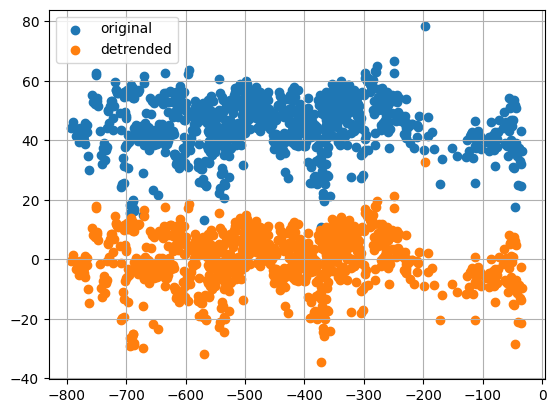

In [9]:
plt.scatter(df["Z"].values, df["Porosity"].values, label = "original")
plt.scatter(df["Z"].values, df["Residuals"].values, label = "detrended")
plt.legend()

### 2.3 Horizontal trend

We expect a trend of increasing porosity in oceanward direction. Here a simple linear trend is fitted to the mean residuals of the three available wells. A trend in strike direction ist not expected and cannot be inferred based on well locations.

In [10]:
# Linear trend model
def linear_trend(x, a, b):
    return a+b*x

In [11]:
# Horizontal trend calculation and plotting

# Rename data for simplicity
xdata = np.unique(df["Y"].values)
ydata = np.array([np.mean(df[df["Well"]=="m27"]["Residuals"]), 
                  np.mean(df[df["Well"]=="m28"]["Residuals"]), 
                  np.mean(df[df["Well"]=="m29"]["Residuals"])])

# Trend fitting linear trend
popt_lin, pcov_lin = curve_fit(linear_trend, xdata, ydata) 

# Calculate r^2 exponential
residuals = ydata-linear_trend(xdata, *popt_lin)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared_lin = 1 - (ss_res / ss_tot)

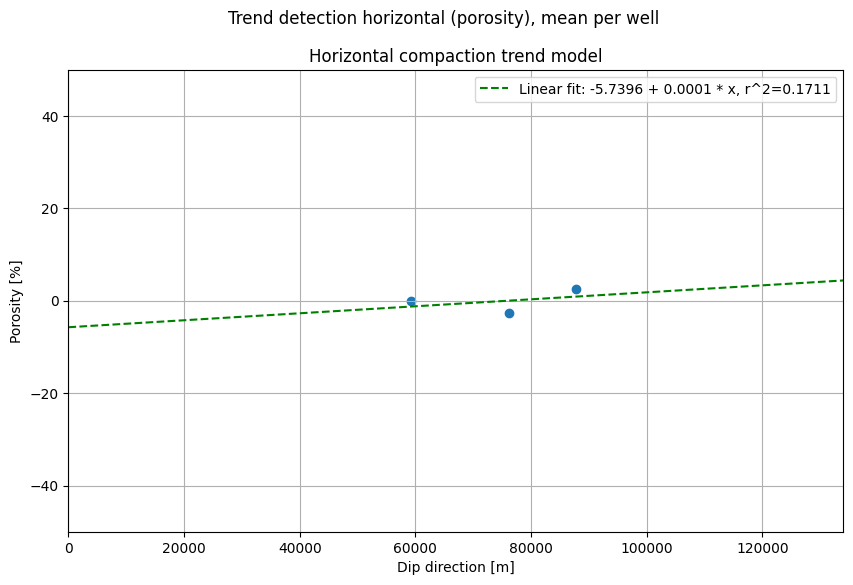

In [12]:
# Create figure
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
fig.suptitle('Trend detection horizontal (porosity), mean per well')

# Plot data
axs.scatter(xdata, ydata)

# Plot linear trend
axs.plot(np.arange(0,134000,1), linear_trend(np.arange(0,134000,1), *popt_lin), 'g--',
    label='Linear fit: {} + {} * x, r^2={}'.format(
    np.round(popt_lin[0],4), np.round(popt_lin[1], 4), np.round(r_squared_lin,4)))

# Plot design
axs.set(xlabel='Dip direction [m]', ylabel='Porosity [%]', 
        title='Horizontal compaction trend model',
        ylim=(-50, 50), xlim=(0, 134000))

axs.legend()
fig.savefig('Figures\Horizontal_trend.jpg',dpi=450,bbox_inches='tight')
#plt.savefig("Figures/Horizontal_trend", dpi=150)

plt.show()

### 2.3 Detrend data (dip)

In [13]:
# Remove trend using expoential trend
df["Residuals"] = df["Residuals"].values - linear_trend(df["Y"].values, *popt_lin)

## 3. Normal score transformation

As we plan to perform Gaussian Simulation, we need to transform the data to fit a normal distribution. We need to back transform after the simulation (and reapply the trends).

In [14]:
# normal score transform data
# Code source:
# http://connor-johnson.com/2014/06/12/z-score-transform-for-geostatistics/

In [15]:
# Relevant functions
def cdf(d, bins=12 ):
    N = len( d )
    counts, intervals = np.histogram( d, bins=bins )
    h = np.diff( intervals ) / 2.0
    f, finv = np.zeros((N,2)), np.zeros((N,2))
    idx, k, T = 0, 0, float( np.sum( counts ) )
    for count in counts:
        for i in range( count ):
            x = intervals[idx]+h[0]
            y = np.cumsum( counts[:idx+1] )[-1] / T
            f[k,:] = x, y 
            finv[k,:] = y, x
            k += 1
        idx += 1
    return f, finv

def fit(d):
    x, y = d[:,0], d[:,1]
    def f(t):
        if t <= x.min():
            return y[ np.argmin(x) ]
        elif t >= x.max():
            return y[ np.argmax(x) ]
        else:
            intr = scipy.interpolate.interp1d( x, y )
            return intr(t)
    return f

# transform data to normal dist
def to_norm( data, bins=10000):
    mu = np.mean( data )
    sd = np.std( data )
    z = ( data - mu ) / sd
    f, inv = cdf( z, bins=bins )
    z = scipy.stats.norm(0,1).ppf( f[:,1] )
    z = np.where( z==np.inf, np.nan, z )
    z = np.where( np.isnan( z ), np.nanmax( z ), z )
    param = ( mu, sd )
    return z, inv, param, mu, sd
 
# transform data from normal dist back
def from_norm( data, inv, param, mu, sd ):
    h = fit( inv )
    f = scipy.stats.norm(0,1).cdf( data )
    z = [ h(i)*sd + mu for i in f ]
    return z

In [16]:
# N-score transformation all
por_residuals_norm_transform, inv, param, m, sd = to_norm(df["Residuals"].values)

# Add result to dataframe
df["Nscore Residuals"]=por_residuals_norm_transform

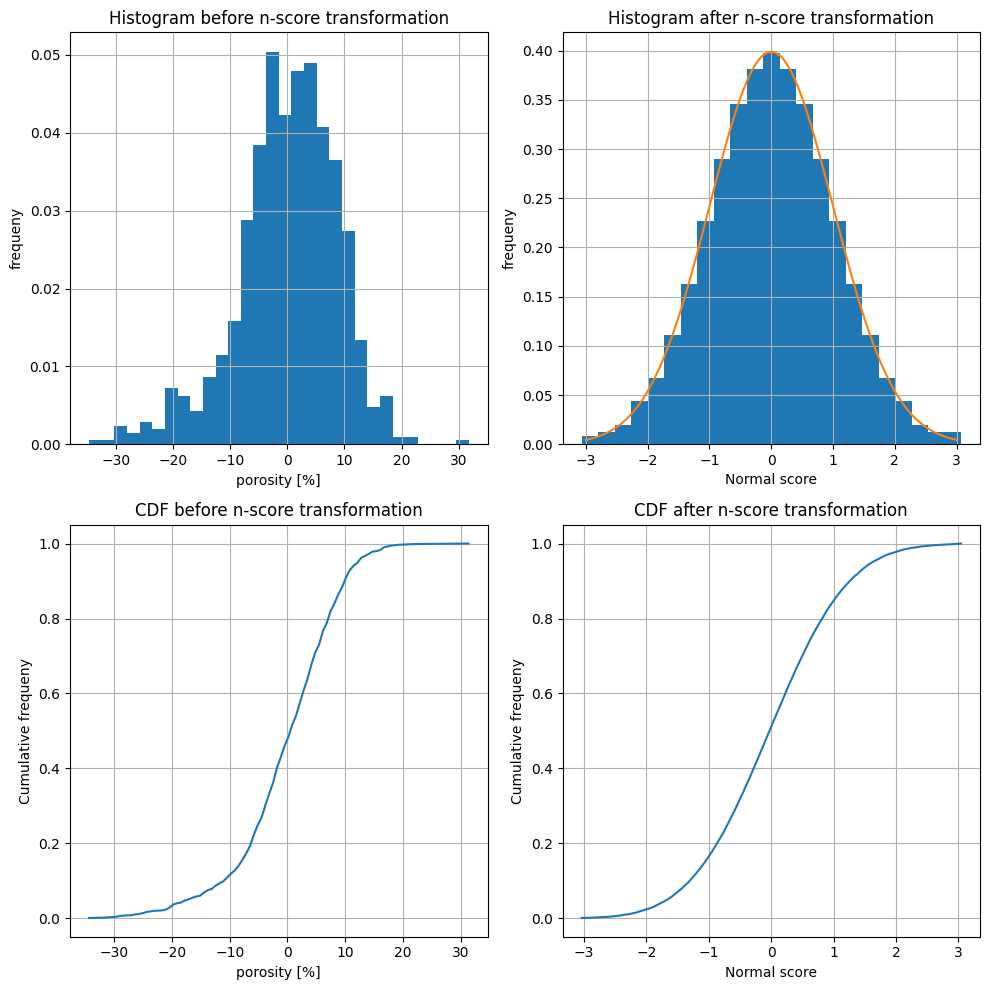

In [17]:
# Plot to compare original versus transformed
fig,axs=plt.subplots(2,2,figsize=(10,10)) 
x=np.linspace(-3,3,100)

# Histogram before
axs[0][0].set(title='Histogram before n-score transformation', xlabel='porosity [%]', ylabel='frequeny')
axs[0][0].hist(df["Residuals"].values, bins='fd', density=True)

# Histogram after
axs[0][1].set(title='Histogram after n-score transformation', xlabel='Normal score', ylabel='frequeny')
axs[0][1].hist(df["Nscore Residuals"].values, bins='fd', density=True)
axs[0][1].plot(x, scipy.stats.norm.pdf(x, 0, 1))

# cdf before
res_before, res_inv_before = cdf(df["Residuals"].values, bins=100)
axs[1][0].set(title='CDF before n-score transformation', xlabel='porosity [%]', ylabel='Cumulative frequeny')
axs[1][0].plot(res_before[:,0], res_before[:,1])

# cdf after
res_after, res_inv_after = cdf(df["Nscore Residuals"].values, bins=100)
axs[1][1].set(title='CDF after n-score transformation', xlabel='Normal score', ylabel='Cumulative frequeny')
axs[1][1].plot(res_after[:,0], res_after[:,1])

plt.tight_layout()
plt.savefig("Figures/N-score transform")

## 4. Variogram Modeling

Now we start vertical variogram modeling on the detrended and transformed data. We start by creating an empty frame for our modeling results.

In [18]:
# Create empty df for varigoram results
variogram_results =pd.DataFrame(columns=("Sequence", "Model", 
                                        "Z Range (Well Data)", 
                                        "Y Angle (Attr)", "Y Range (Attr)",
                                        "X Angle (Attr)", "X Range (Attr)",
                                        "Anisotropy Ratio (X/Y/Z)",
                                        "Comment"))

variogram_results["Sequence"]=np.unique(df["Sequence"].values)

variogram_results

,Sequence,Model,Z Range (Well Data),Y Angle (Attr),Y Range (Attr),X Angle (Attr),X Range (Attr),Anisotropy Ratio (X/Y/Z),Comment
0,m1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,m41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,m5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,m54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,m58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,m6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,o1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.1. Vertical variogram

### 4.1.1 Experimental vertical variogram

Standard variogram modeling for vertical direction based on core porosity data.

Three approaches shown here: 
- 1) Global
- 2) Per well
- 3) Per sequence

In [19]:
# Define extent of "well domain"
well_dom = (df["Z"].min()-df["Z"].max())*(-1)

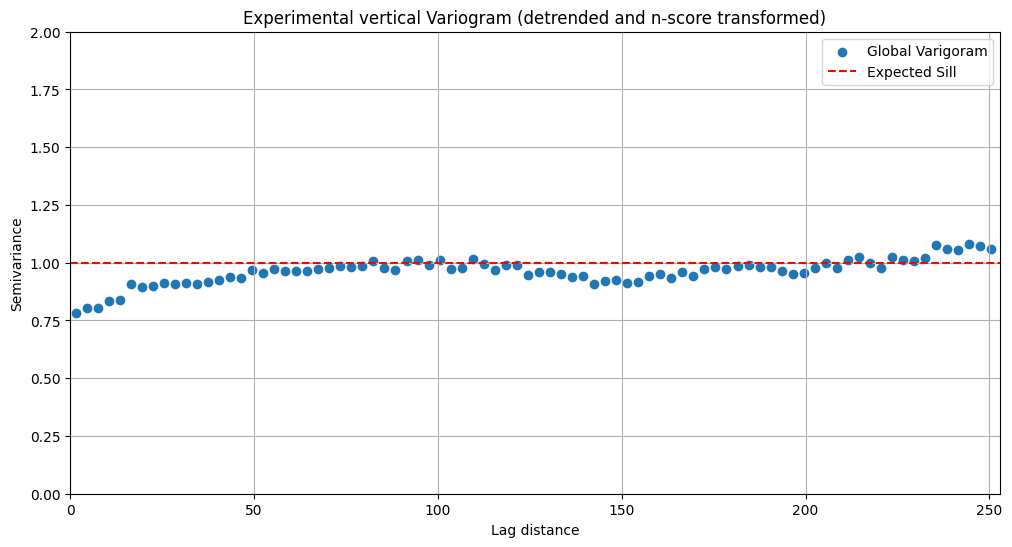

In [20]:
# Experimental vertical variogram global
fig,ax=plt.subplots(figsize=(12,6)) # Erstellung der Subplots
ax.set(title='Experimental vertical Variogram (detrended and n-score transformed)', 
       xlabel='Lag distance', ylabel='Semivariance', xlim=(0,well_dom/3), ylim=(0,2))

bins = np.arange(0, well_dom/3, 3) # binsize = sample spacing - literature
bin_center, gamma = gs.vario_estimate_unstructured((np.zeros(len(df["Z"].values)), 
                                                            df["Z"].values), 
                                                            df["Nscore Residuals"].values, bins)
ax.scatter(bin_center, gamma, label="Global Varigoram")
ax.plot([0,well_dom/3],[1,1], "r--", label="Expected Sill")
plt.legend()
plt.show()

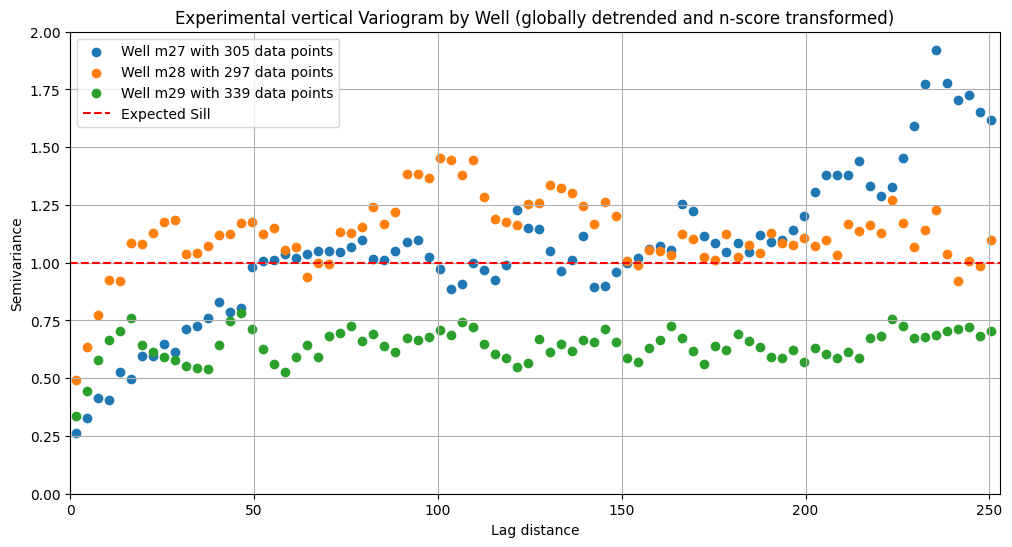

In [21]:
# Experimental vertical varigoram per well
fig,ax=plt.subplots(figsize=(12,6)) #Erstellung der Subplots
ax.set(title='Experimental vertical Variogram by Well (globally detrended and n-score transformed)', 
       xlabel='Lag distance', ylabel='Semivariance', xlim=(0,well_dom/3), ylim=(0,2))

bins = np.arange(0, well_dom/3, 3)
for i in np.unique(df["Well"]):
    bin_center_seq, gamma_seq = gs.vario_estimate_unstructured((np.zeros(len(df["Z"][df["Well"]==i].values)), 
                                                            df["Z"][df["Well"]==i].values), 
                                                            df["Nscore Residuals"][df["Well"]==i].values, bins)
    ax.scatter(bin_center_seq, gamma_seq, label="Well {} with {} data points".format(i, len(df[df["Well"]==i])))

ax.plot([0,well_dom/3],[1,1], "r--", label="Expected Sill")
plt.legend()
plt.show()

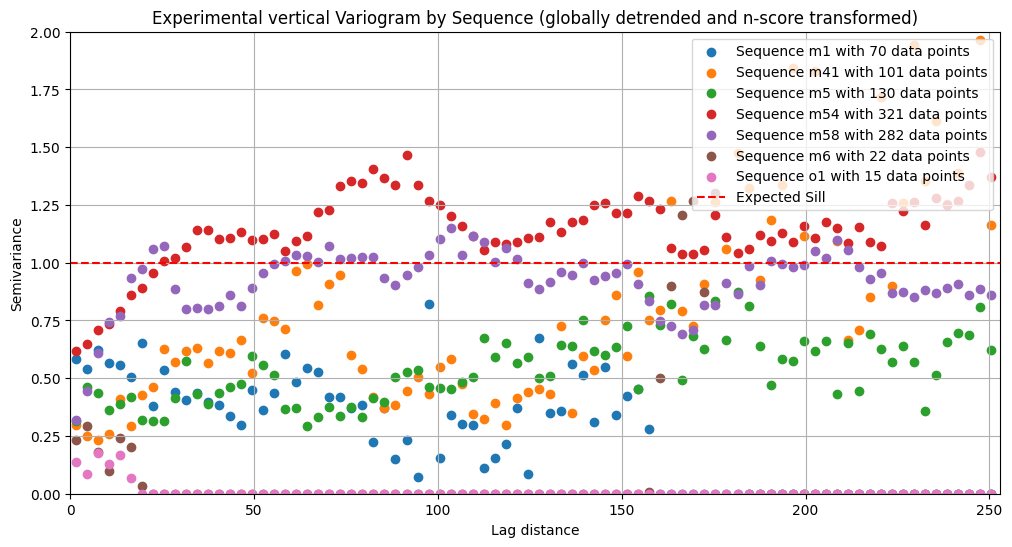

In [22]:
# Experimental vertical varigoram per sequence
fig,ax=plt.subplots(figsize=(12,6)) 
ax.set(title='Experimental vertical Variogram by Sequence (globally detrended and n-score transformed)', 
       xlabel='Lag distance', ylabel='Semivariance', xlim=(0,well_dom/3), ylim=(0,2))

bins = np.arange(0, well_dom/3, 3)
for i in np.unique(df["Sequence"]):
    bin_center_seq, gamma_seq = gs.vario_estimate_unstructured((np.zeros(len(df["Z"][df["Sequence"]==i].values)), 
                                                            df["Z"][df["Sequence"]==i].values), 
                                                            df["Nscore Residuals"][df["Sequence"]==i].values, bins)
    ax.scatter(bin_center_seq, gamma_seq, label="Sequence {} with {} data points".format(i, len(df[df["Sequence"]==i])))

ax.plot([0,well_dom/3],[1,1], "r--", label="Expected Sill")
plt.legend(loc="upper right")
plt.show()

### 4.1.2 Theoretical vertical variogram

We need to fit a single theoretical variogram model (plus nugget effect). Nested structures (especially in different directions) are supported by GSTools, but might anyway lead to overfitting to specific data. 

Experimental variograms.
- 1) Global - cross well correlation leads to overestiamtion of nugget effect.
- 2) Per Sequence - Not enough data to model individual sequences.
- 3) Per well - Reasonable variograms.

Based on these considerations the theoretical variogram was fitted to the well data M28, as this well has a central location and covers most sequences.

In [23]:
# N-score transform M28 only to fix sill
por_residuals_norm_transform_m28, inv_m28, param_m28, m_m28, sd_m28 = to_norm(df["Residuals"][df["Well"]=="m28"].values)

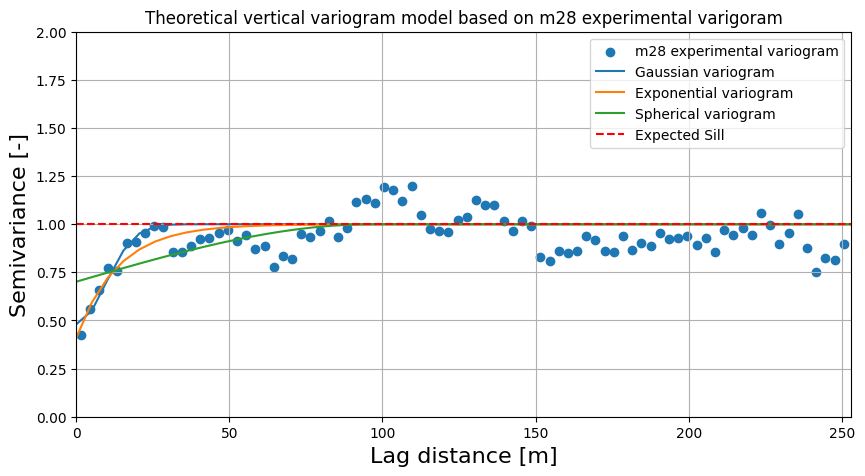

In [24]:
# Fit theoretical varigoram models
# https://geostat-framework.readthedocs.io/projects/gstools/en/latest/examples/03_variogram/01_find_best_model.html
fig,ax=plt.subplots(figsize=(10,5)) #Erstellung der Subplots
ax.set(title='Theoretical vertical variogram model based on m28 experimental varigoram', 
       xlabel='Lag distance [m]', ylabel='Semivariance [-]', xlim=(0,well_dom/3), ylim=(0,2))

bins = np.arange(0, well_dom/3, 3) # max h third of domain, 3 as sample spacing
bin_center_seq_m28, gamma_seq_m28, count = gs.vario_estimate((np.zeros(len(df["Z"][df["Well"]=="m28"].values)), 
                                                            df["Z"][df["Well"]=="m28"].values), 
                                                            por_residuals_norm_transform_m28, bins, return_counts=True)

ax.scatter(bin_center_seq_m28, gamma_seq_m28, label="m28 experimental variogram")

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    #"Matern": gs.Matern,
    #"Stable": gs.Stable,
    #"Rational": gs.Rational,
    #"Circular": gs.Circular,
    "Spherical": gs.Spherical,
    #"SuperSpherical": gs.SuperSpherical,
    #"JBessel": gs.JBessel,
}

scores = {}
ranges = {}

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    # Fixed sill to 1!!! because of known variance
    para, pcov, r2 = fit_model.fit_variogram(bin_center_seq_m28, gamma_seq_m28, return_r2=True, sill=1)
    fit_model.plot(x_max=well_dom/3, ax=ax)
    scores[model] = r2
    ranges[model] = fit_model.len_scale

ax.plot([0,well_dom/3],[1,1], "r--", label="Expected Sill")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.legend()
plt.show()

fig.savefig("Figures/Vertical_variogram.jpg",dpi=450,bbox_inches='tight')

In [25]:
# Rank fitted models by r2 score
ranking = [
    (k, v)
    for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)]

print("RANKING")
for i, (model, score) in enumerate(ranking, 1):
    print(i, model, score)
    print("RANGE:", ranges[model])

plt.show()

RANKING
1 Exponential 0.31444586330864144
RANGE: 13.6965270579501
2 Gaussian 0.28638596941345584
RANGE: 11.857175245114764
3 Spherical 0.2264538403762698
RANGE: 96.63463897424589


In [26]:
# Add results to dataframe
variogram_results["Model"][:]="Exponential"
variogram_results["Z Range (Well Data)"][:]=ranges["Exponential"] 

variogram_results

,Sequence,Model,Z Range (Well Data),Y Angle (Attr),Y Range (Attr),X Angle (Attr),X Range (Attr),Anisotropy Ratio (X/Y/Z),Comment
0,m1,Exponential,13.697,NaN,NaN,NaN,NaN,NaN,NaN
1,m41,Exponential,13.697,NaN,NaN,NaN,NaN,NaN,NaN
2,m5,Exponential,13.697,NaN,NaN,NaN,NaN,NaN,NaN
3,m54,Exponential,13.697,NaN,NaN,NaN,NaN,NaN,NaN
4,m58,Exponential,13.697,NaN,NaN,NaN,NaN,NaN,NaN
5,m6,Exponential,13.697,NaN,NaN,NaN,NaN,NaN,NaN
6,o1,Exponential,13.697,NaN,NaN,NaN,NaN,NaN,NaN


## 4.2 Horizontal variograms

The low well count does not allow varigoram estimation based on well data in horzontal directions. Thus variogram analysis is based on seismic cross sections. A downslope geometry (y direction) is present, as well as a vergency along strike (x) - rotational variograms needed to estimate direction of maximum continuity.

### 4.1.1 Dip: Example workflow (and visualization) for single sequence

In [27]:
# Import sections
section_df = pd.read_csv("Data/Attr_dip/m54_attr_sm_xyz_clean_ran.txt") 
section_df = section_df.rename(columns={'#X': 'X', 'attr ': 'attr'})

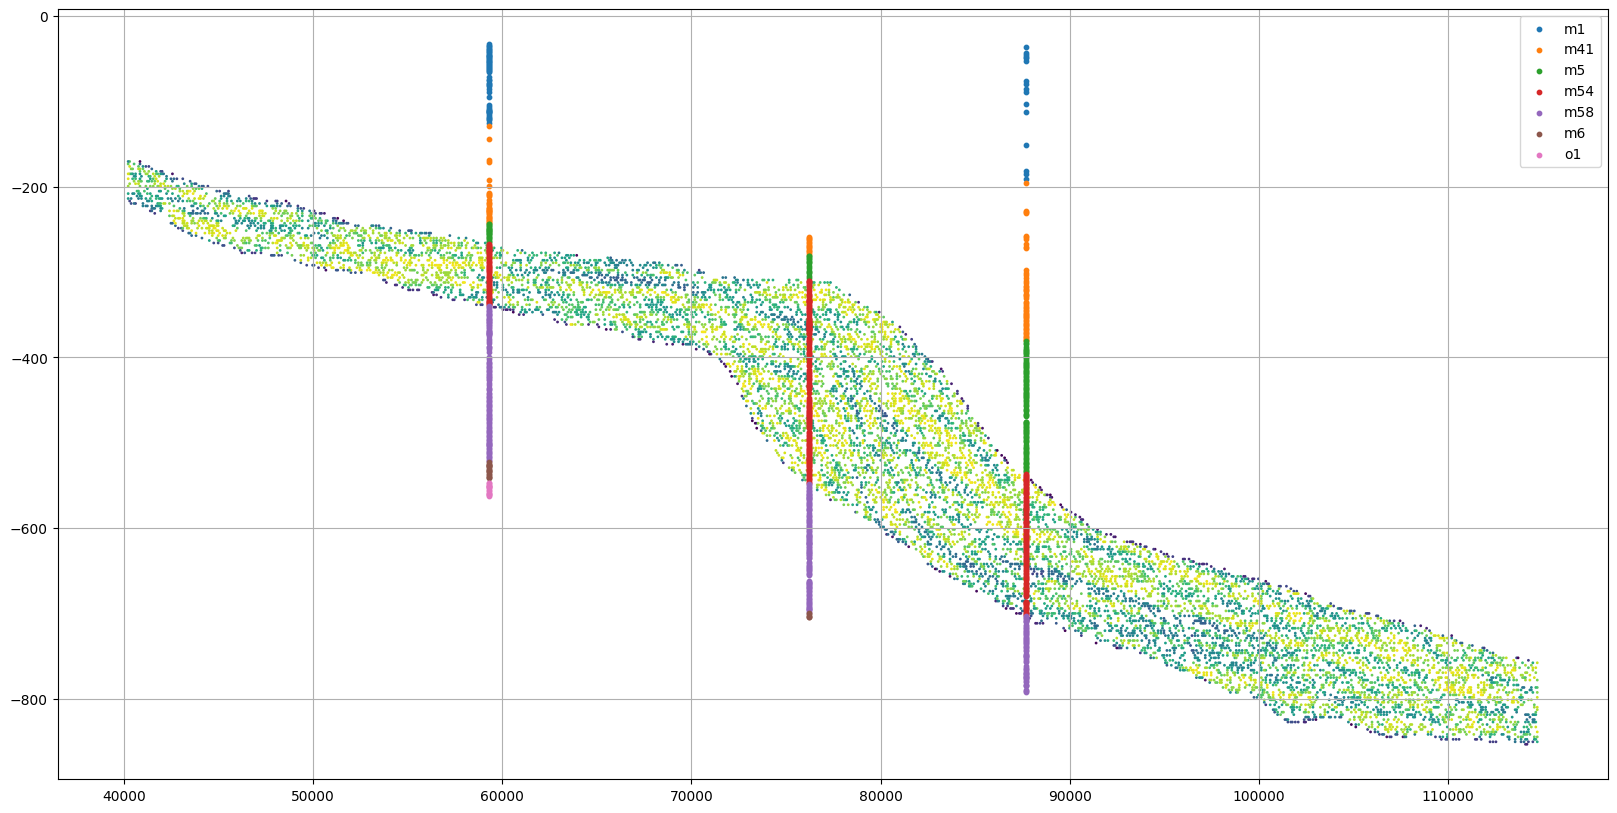

In [28]:
# Plot sequence and wells
plt.figure(figsize=(20,10))
plt.scatter(section_df["Y"].values, 
            section_df["Z"].values, 
            c=section_df["attr"].values, cmap="viridis", s=1)

for i in np.unique(df["Sequence"].values):
    plt.scatter(df["Y"][df["Sequence"]==i].values, df["Z"][df["Sequence"]==i].values, s=10, label=i)

plt.legend()
plt.show()

Angle: -1.0 / Range: 830.7223 / Mincount: 10332
Angle: -0.9 / Range: 832.5223 / Mincount: 12487
Angle: -0.8 / Range: 818.1914 / Mincount: 14917
Angle: -0.7 / Range: 958.278 / Mincount: 15739
Angle: -0.6 / Range: 1106.752 / Mincount: 17417
Angle: -0.5 / Range: 1309.177 / Mincount: 17549
Angle: -0.4 / Range: 1571.591 / Mincount: 17609
Angle: -0.3 / Range: 1511.254 / Mincount: 15827
Angle: -0.2 / Range: 1524.1151 / Mincount: 11446
Angle: -0.1 / Range: 1988.8095 / Mincount: 5201


(0.0, 0.045260312482211844)

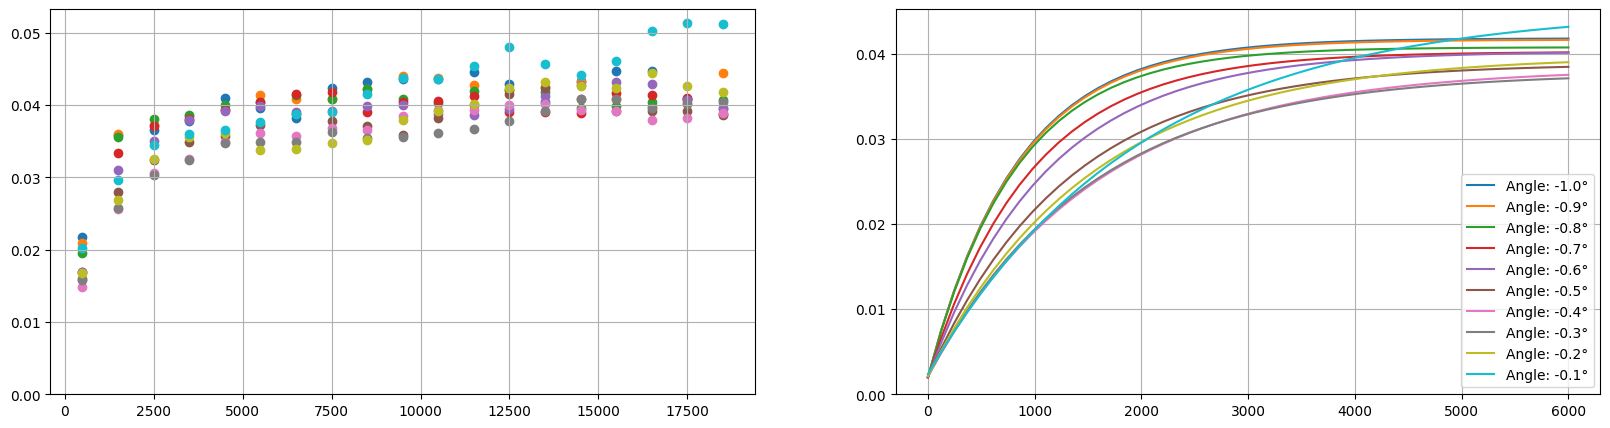

In [29]:
dim = 2
bins = np.arange(0, 60000/3, 1000) # Half of full image width, bins roughly equal to spacing
steps = 0.1 
angles_deg = np.arange(-1.0, 0, steps) 
angles_rad = np.deg2rad(angles_deg)

# initiate figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])

for i in range(len(angles_deg)):
    
    # get main axes 
    main_axes = gs.rotated_main_axes(dim, angles_rad[i])
    axis1, axis2 = main_axes
    
    # calculate directional variogram
    bin_center, dir_vario, counts = gs.vario_estimate(
    *((section_df["Y"].values, section_df["Z"].values), 
      section_df["attr"].values, 
      bins),
    direction=gs.rotated_main_axes(dim=2, angles=angles_rad[i]),
    angles_tol=np.pi / 8,
    bandwidth=2,
    mesh_type="unstructured",
    return_counts=True)

    # plot experimental variogram
    ax1.scatter(bin_center, dir_vario[0], label="Angle: {}°".format(angles_deg[i]))
    
    # create model
    model = gs.Exponential(dim=2, len_scale=[2000, 1], angles=angles_rad[i])
    
    model.fit_variogram(bin_center, dir_vario)
    model.plot("vario_axis", axis=0, ax=ax2, x_max=6000, label="Angle: {}°".format(np.round(angles_deg[i], 4)))
    
    print("Angle: {} / Range: {} / Mincount: {}".format(np.round(angles_deg[i],4), 
                                                        np.round(model.len_scale,4),
                                                        np.min(counts[0])))

ax1.set_ylim(0)
ax2.set_ylim(0)
#plt.legend()

### 4.2.2 Automated Picking of highest range for y-direction

Automated workflow to calculate angle and range for each sequence based on seismic and picked theoretical variogram model.

Workflow:
- Iterate over each sequence
- Iterate over range of angles
- For each sequence save angle with highest range and a minimum of 500 pointpairs per bin

In [30]:
# Import seismic sections, randomly sampled 10%
seismic_dip_lines = {"m1": pd.read_csv("Data/Attr_dip/m1_attr_sm_xyz_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"], dtype="float"),
                    "m5": pd.read_csv("Data/Attr_dip/m5_attr_sm_xyz_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"], dtype="float"),
                    "m6": pd.read_csv("Data/Attr_dip/m6_attr_sm_xyz_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"], dtype="float"),
                    "m41": pd.read_csv("Data/Attr_dip/m41_attr_sm_xyz_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"], dtype="float"),
                    "m54": pd.read_csv("Data/Attr_dip/m54_attr_sm_xyz_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"], dtype="float"),
                    "m58": pd.read_csv("Data/Attr_dip/m58_attr_sm_xyz_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"], dtype="float"),
                    "o1": pd.read_csv("Data/Attr_dip/o1_attr_sm_xyz_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"], dtype="float")}

In [31]:
# Set parameters
dim = 2
bins = np.arange(0, 60000/3, 1000) # Half of full image width, bins roughly equal to spacing
steps = 0.01 
angles_deg = np.arange(-1, 0, steps) # Angle range
angles_rad = np.deg2rad(angles_deg)

In [32]:
%%time
# Iteratively finding dip direction of highest continuity
res_range_all = []
res_angle_all = []

for j in np.unique(df["Sequence"].values):
    
    print (j)
    
    # empty start
    res_angle = 0
    res_range = 0
    
    for i in range(len(angles_deg)):
        
        # get main axes 
        main_axes = gs.rotated_main_axes(dim, angles_rad[i])
        axis1, axis2 = main_axes

        # calculate directional variogram
        bin_center, dir_vario, counts = gs.vario_estimate(
        *((seismic_dip_lines[j]["Y"].values, 
           seismic_dip_lines[j]["Z"].values), 
          seismic_dip_lines[j]["attr"].values, 
          bins),
        direction=gs.rotated_main_axes(dim=2, angles=angles_rad[i]),
        angles_tol=np.pi / 8, # small
        bandwidth=2, # very small - literature
        mesh_type="unstructured",
        return_counts=True)

        # create model
        model = gs.Exponential(dim=2, len_scale=[2000, 1], angles=angles_rad[i])
        model.fit_variogram(bin_center, dir_vario, max_eval=10000)

        # safe angle and range if range higher than before (finding highest range)
        if model.len_scale > res_range:
            if np.min(counts[0]) > 2500:
                res_range = model.len_scale
                res_angle = angles_deg[i]
    
    res_range_all.append(res_range)
    res_angle_all.append(res_angle)
    

m1


In [ ]:
# Add results to dataframe
variogram_results["Y Angle (Attr)"]=np.round(res_angle_all,4)
variogram_results["Y Range (Attr)"]=np.round(res_range_all,4)
variogram_results

### 4.2.3 Strike (X-Direction): Example workflow for single sequence

In [ ]:
# Import section
section_df = pd.read_csv("Data/Attr_strike/m41_attr_sm_str_xyz_strike_clean_ran.txt") 
section_df = section_df.rename(columns={'#X': 'X', 'attr ': 'attr'})

In [ ]:
# Plot sequence and wells
plt.figure(figsize=(20,10))
plt.scatter(section_df["X"].values, 
            section_df["Z"].values, 
            c=section_df["attr"].values, cmap="viridis", s=1)
 
for i in np.unique(df["Sequence"].values):
    plt.scatter(df["X"][df["Sequence"]==i].values, df["Z"][df["Sequence"]==i].values, s=10, label=i)

# Necessary to display correctly
ax = plt.gca()
ax.invert_xaxis()
plt.legend()

In [ ]:
dim = 2
bins = np.arange(0, 50000/3, 1000) # Half of full image width, bins roughly equal to spacing
steps = 0.1 
angles_deg = np.arange(-0.5, 0.5, steps) # Angle range
angles_rad = np.deg2rad(angles_deg)

# initiate figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])

for i in range(len(angles_deg)):
    
    # get main axes 
    main_axes = gs.rotated_main_axes(dim, angles_rad[i])
    axis1, axis2 = main_axes
    
    # calculate directional variogram
    bin_center, dir_vario, counts = gs.vario_estimate(
    *((section_df["X"].values, 
       section_df["Z"].values), 
      section_df["attr"].values, 
      bins),
    direction=gs.rotated_main_axes(dim=2, angles=angles_rad[i]),
    angles_tol=np.pi / 8,
    bandwidth=2,
    mesh_type="unstructured",
    return_counts=True)

    # plot experimental variogram
    ax1.scatter(bin_center, dir_vario[0], label="Angle: {}°".format(angles_deg[i]))
    
    # create model
    model = gs.Exponential(dim=2, len_scale=[2000, 1], angles=angles_rad[i])
    
    model.fit_variogram(bin_center, dir_vario)
    model.plot("vario_axis", axis=0, ax=ax2, x_max=6000, label="Angle: {}°".format(np.round(angles_deg[i], 4)))
    #plt.plot("vario_axis", axis=1, ax=ax1, x_max=40, label="fit on axis 1")
    
    #print(model)
    print("Angle: {} / Range: {} / Mincount: {}".format(np.round(angles_deg[i],4), 
                                                        np.round(model.len_scale,4),
                                                        np.min(counts[0])))


ax1.set_ylim(0)
ax2.set_ylim(0)

### 4.2.4 Automated Picking of highest range for x-direction

In [ ]:
# Import seismic sections, randomly sampled 10%
seismic_strike_lines = {"m1": pd.read_csv("Data/Attr_strike/m1_attr_sm_str_xyz_strike_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"]),
                    "m5": pd.read_csv("Data/Attr_strike/m5_attr_sm_str_xyz_strike_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"]),
                    "m6": pd.read_csv("Data/Attr_strike/m6_attr_sm_str_xyz_strike_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"]),
                    "m41": pd.read_csv("Data/Attr_strike/m41_attr_sm_str_xyz_strike_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"]),
                    "m54": pd.read_csv("Data/Attr_strike/m54_attr_sm_str_xyz_strike_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"]),
                    "m58": pd.read_csv("Data/Attr_strike/m58_attr_sm_str_xyz_strike_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"]),
                    "o1": pd.read_csv("Data/Attr_strike/o1_attr_sm_str_xyz_strike_clean_ran.txt", skiprows=[0], names=["X", "Y", "Z", "attr"])}


In [ ]:
# Set parameters
dim = 2
bins = np.arange(0, 50000/3, 1000) # Half of fill iamge width, bins roughly equal to spacing  - literature
steps = 0.01 
angles_deg = np.arange(-0.5, 0.6, steps) # Angle range
angles_rad = np.deg2rad(angles_deg)

In [ ]:
%%time
# Iteratively finding strike direction of highest continuity
res_range_all = []
res_angle_all = []

for j in np.unique(df["Sequence"].values):
    
    print (j)
    
    # empty start
    res_angle = 0
    res_range = 0
    
    for i in range(len(angles_deg)):
        
        # get main axes 
        main_axes = gs.rotated_main_axes(dim, angles_rad[i])
        axis1, axis2 = main_axes

        # calculate directional variogram
        bin_center, dir_vario, counts = gs.vario_estimate(
        *((seismic_strike_lines[j]["X"].values, 
           seismic_strike_lines[j]["Z"].values), 
          seismic_strike_lines[j]["attr"].values, 
          bins),
        direction=gs.rotated_main_axes(dim=2, angles=angles_rad[i]),
        angles_tol=np.pi / 8, # small
        bandwidth=2, # very small - literature
        mesh_type="unstructured",
        return_counts=True)

        # create model
        model = gs.Exponential(dim=2, len_scale=[1000, 1], angles=angles_rad[i])
        model.fit_variogram(bin_center, dir_vario, max_eval=10000)
       
        # save angle and range if range higher than before (finding highest range)
        if model.len_scale > res_range:
            if np.min(counts[0]) > 2500:
                res_range = model.len_scale
                res_angle = angles_deg[i]
    
    res_range_all.append(res_range)
    res_angle_all.append(res_angle)
    

In [ ]:
variogram_results["X Angle (Attr)"]=np.round(res_angle_all,4)
variogram_results["X Range (Attr)"]=np.round(res_range_all,4)
variogram_results

### 5. Results

Final results table with anisotropy ratio:

In [ ]:
# Calculate anisotropy ratios and add to df
ratios = np.zeros((len(np.unique(df["Sequence"].values)),3))

ratios[:,2]=variogram_results["Z Range (Well Data)"].values/variogram_results["Z Range (Well Data)"].values
ratios[:,0]=variogram_results["X Range (Attr)"].values/variogram_results["Z Range (Well Data)"].values
ratios[:,1]=variogram_results["Y Range (Attr)"].values/variogram_results["Z Range (Well Data)"].values

ratios = np.round(ratios,0).astype(int)

# correct strike angle direction
variogram_results["X Angle (Attr)"]=variogram_results["X Angle (Attr)"]*(-1)

for i in range((len(np.unique(df["Sequence"].values)))):
    variogram_results["Anisotropy Ratio (X/Y/Z)"][i]=ratios[i]

In [ ]:
# Final results (RAW)
variogram_results

In [ ]:
# Add comments 
variogram_results["Comment"][variogram_results["Sequence"]=="m1"]="*Strike direction corrected (underlying sequence) - seismic processing"
variogram_results["Comment"][variogram_results["Sequence"]=="m41"]=""
variogram_results["Comment"][variogram_results["Sequence"]=="m5"]="*Strike direction corrected (underlying sequence) - lacking data"
variogram_results["Comment"][variogram_results["Sequence"]=="m54"]=""
variogram_results["Comment"][variogram_results["Sequence"]=="m58"]=""
variogram_results["Comment"][variogram_results["Sequence"]=="m6"]=""
variogram_results["Comment"][variogram_results["Sequence"]=="o1"]=""

# Manual corrections
variogram_results["X Range (Attr)"][0]=variogram_results["X Range (Attr)"][1]
variogram_results["X Angle (Attr)"][0]=0
variogram_results["X Range (Attr)"][2]=variogram_results["X Range (Attr)"][3]

# Recalcuclate anisotropy ratios
# calcualte anisotropy ratios and add to df
ratios = np.zeros((len(np.unique(df["Sequence"].values)),3))

ratios[:,2]=variogram_results["Z Range (Well Data)"].values/variogram_results["Z Range (Well Data)"].values
ratios[:,0]=variogram_results["X Range (Attr)"].values/variogram_results["Z Range (Well Data)"].values
ratios[:,1]=variogram_results["Y Range (Attr)"].values/variogram_results["Z Range (Well Data)"].values

ratios = np.round(ratios,0).astype(int)

for i in range((len(np.unique(df["Sequence"].values)))):
    variogram_results["Anisotropy Ratio (X/Y/Z)"][i]=ratios[i]

In [ ]:
# Final results (corrected)
variogram_results

In [ ]:
variogram_results.to_csv("Results/Variogram results table.csv")

In [ ]:
#print(variogram_results.to_latex(index=False))